In [2]:
import numpy as np
import pandas as pd
from CAPM import *
from drawdown import *
from tseries import *
from block_bootstrap import *

선배님 작성하신 코드 사용하려고 했는데 yfinance가 작동을 안해서 csv 파일 사용했음.

In [ ]:
SP_data()

S&P500 종목 리스트 가져오는 중...
시가총액 데이터 가져오는 중...(시간 약간 걸려요)


In [3]:
sp500_df = pd.read_csv('sp500.csv')
sp500_df

,Ticker,Name,Sector,Subsector,MarketCap
0,MMM,3M,Industrials,Industrial Conglomerates,NaN
1,AOS,A. O. Smith,Industrials,Building Products,NaN
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,NaN
3,ABBV,AbbVie,Health Care,Biotechnology,NaN
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,NaN
...,...,...,...,...,...
509,GSG,iShares S&P GSCI Commodity-Indexed Trust ETF,Commodity Index,Composite Commodity,NaN
510,SLV,iShares Silver Trust,Commodity Index,Silver,NaN
511,TLT,iShares 20+ Year Treasury Bond ETF,Bond,Long-term Bond,NaN
512,SHY,Vanguard Total Bond Market Index Fund ETF,Bond,Composite Bond,NaN


데이터 로드

In [4]:
selected_price_data = pd.read_csv("selected_price_data.csv")
selected_price_data = selected_price_data.set_index('Date')

1년, 3년 단순 누적 수익률 계산

In [5]:
cum_returns_1yr, cum_returns_3yr = price_data(selected_price_data)

최소, 최대비중 및 누적 수익률 어떤 것 쓸 것인지 계산

In [6]:
x_min = 0.005
x_max = 0.5
y = cum_returns_1yr

Max Drawdown 모형, gamma는 최대 허용 drawdown 의미, 일단은 논문 값 기반으로 했는데 historical data 확인하고 적당히 잡아도 괜찮을듯! 근데 너무 작으면 코드가 작동을 안함..

In [7]:
#m, x, u = maxdd_model(cum_returns_1yr, 0.08, x_min, x_max)
gamma_lst = [x/100 for x in range(4, 31)]
results_maxdd = []
results_maxdd_weights = []
for gamma in gamma_lst:
    model, x_var, u_var, max_dd_var = maxdd_model(y, gamma, x_min, x_max, leverage=None)
    model.optimize()

    # 1) 최적 비중 벡터
    x_opt = np.array([x_var[i].X for i in range(len(x_var))])

    # 2) 누적수익 시계열 (numpy 계산)
    w_vals = y.values @ x_opt                 # shape (T,)

    # 3) running max, drawdown
    u_vals = np.maximum.accumulate(w_vals)    # 벡터
    dd_vals = u_vals - w_vals                 # 벡터

    max_dd = dd_vals.max()


    print(f"Max DD (actual) = {max_dd:.4f}")
    optimal_weight = dict(zip(y.columns, x_opt))
    print(f"Sum of Weights   = {x_opt.sum():.4f}")
    results_maxdd.append({
        "gamma": gamma,
        "max_dd": max_dd,
        "ObjVal": model.ObjVal,
        "Reward/Risk": model.ObjVal / max_dd
    })

    results_maxdd_weights.append(optimal_weight)
# 5) 결과를 DataFrame으로 변환
results_df_1 = pd.DataFrame(results_maxdd)
results_df_2 = pd.DataFrame(results_maxdd_weights)

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13400F, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 757 rows, 302 columns and 25752 nonzeros
Model fingerprint: 0x509bfc09
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [3e-03, 6e-01]
  Bounds range     [5e-03, 5e-01]
  RHS range        [4e-02, 1e+00]
Presolve removed 468 rows and 1 columns
Presolve time: 0.01s
Presolved: 289 rows, 552 columns, 13758 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8960805e-01   6.063884e+01   0.000000e+00      0s
     296    1.7884670e-01   0.000000e+00   0.000000e+00      0s

Solved in 296 iterations and 0.01 seconds (0.02 work units)
Optimal objective  1.788467002e-01
Max DD (actual) = 0.0400
Sum of We

c:\Users\chlwl\Projects\AdvancedPortfolioTheory\MinSeok\drawdown.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.setObjective(quicksum(x[i] * mu[i] for i in range(N)), GRB.MAXIMIZE)



Solved in 321 iterations and 0.01 seconds (0.02 work units)
Optimal objective  2.357647457e-01
Max DD (actual) = 0.0500
Sum of Weights   = 1.0000
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13400F, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 757 rows, 302 columns and 25752 nonzeros
Model fingerprint: 0xe2ba2dce
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [3e-03, 6e-01]
  Bounds range     [5e-03, 5e-01]
  RHS range        [6e-02, 1e+00]
Presolve removed 468 rows and 1 columns
Presolve time: 0.01s
Presolved: 289 rows, 552 columns, 13758 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8960805e-01   6.076884e+01   0.000000e+00      0s
     314    2.8775807e-01   0.000000e+00   0.000000e+00      0s

Solved in 314 iterations and 0.01 seconds (0.02 work

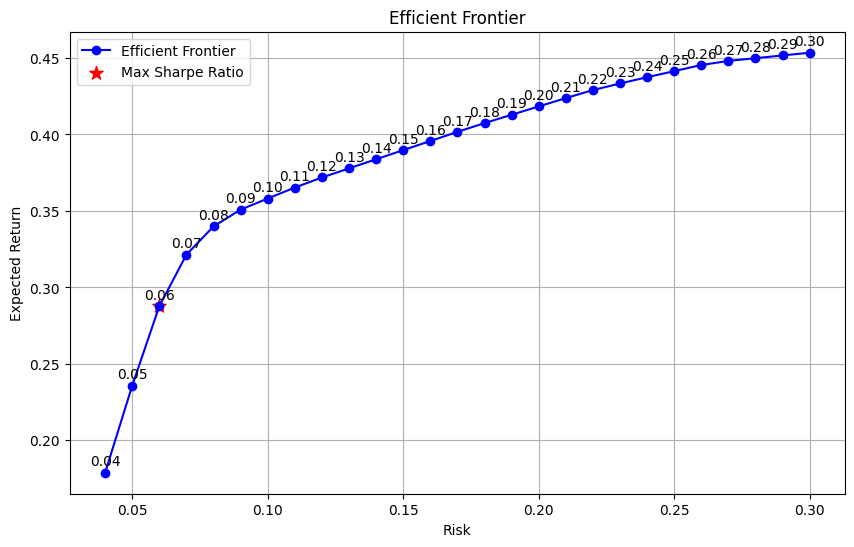

In [8]:
plot_efficient_frontier(results_df_1, "max_dd")

In [9]:
merged_df_maxdd = pd.concat([results_df_1.T, results_df_2.T], axis=0)
merged_df_maxdd.to_csv("maxdd_results_leverage_no.csv")

Avg drawdown 부분. 마찬가지로 gamma는 다른거로 바꿔도 되는데 값이 애매하면 작동을 안함.

In [10]:
#m, x, u = maxdd_model(cum_returns_1yr, 0.08, x_min, x_max)
gamma_lst = list(np.arange(0.02, 0.15, 0.005))
results_avgdd = []
results_avgdd_weights = []
for gamma in gamma_lst:
    model, x_var, u_var, dd_var = avgdd_model(y, gamma, x_min, x_max) #, leverage='Y')
    model.optimize()

    # 1) 최적 비중 벡터
    x_opt = np.array([x_var[i].X for i in range(len(x_var))])

    # 2) 누적수익 시계열 (numpy 계산)
    w_vals = y.values @ x_opt                 # shape (T,)

    # 3) running max, drawdown
    u_vals = np.maximum.accumulate(w_vals)    # 벡터
    dd_vals = u_vals - w_vals                 # 벡터

    avg_dd = dd_vals.mean()

    print(f"Avg DD (actual) = {avg_dd:.4f}")
    print(f"Optimal Weights  = {x_opt}")
    print(f"Sum of Weights   = {x_opt.sum():.4f}")
    results_avgdd.append({
        "gamma": gamma,
        "avg_dd": avg_dd,
        "ObjVal": model.ObjVal,
        "Reward/Risk": model.ObjVal / avg_dd
    })
    optimal_weight = dict(zip(y.columns, x_opt))
    results_avgdd_weights.append(optimal_weight)
results_df_1 = pd.DataFrame(results_avgdd)
results_df_2 = pd.DataFrame(results_avgdd_weights)
merged_df_avgdd = pd.concat([results_df_1.T, results_df_2.T], axis=0)
merged_df_avgdd.to_csv("avgdd_results_leverage.csv")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13400F, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 757 rows, 553 columns and 26255 nonzeros
Model fingerprint: 0x27558fd3
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [3e-03, 6e-01]
  Bounds range     [5e-03, 5e-01]
  RHS range        [2e-02, 1e+00]
Presolve removed 215 rows and 0 columns
Presolve time: 0.01s
Presolved: 542 rows, 553 columns, 27182 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8960805e-01   1.425051e+02   0.000000e+00      0s
     345    3.9464495e-01   0.000000e+00   0.000000e+00      0s

Solved in 345 iterations and 0.02 seconds (0.03 work units)
Optimal objective  3.946449476e-01
Avg DD (actual) = 0.0200
Optimal Weights  = [0.005      0.005      0.005      0.005      0.005      0.00

c:\Users\chlwl\Projects\AdvancedPortfolioTheory\MinSeok\drawdown.py:219: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.setObjective(quicksum(x[i] * mu[i] for i in range(N)), GRB.MAXIMIZE)


Presolve time: 0.01s
Presolved: 542 rows, 553 columns, 27182 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8960805e-01   1.425051e+02   0.000000e+00      0s
     337    4.0730964e-01   0.000000e+00   0.000000e+00      0s

Solved in 337 iterations and 0.02 seconds (0.03 work units)
Optimal objective  4.073096370e-01
Avg DD (actual) = 0.0250
Optimal Weights  = [0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.22641656 0.005      0.12148058 0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.29460254 0.005
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005      0.005      0.005      0.005      0.005      0.13250032
 0.005      0.005      0.005      0.005      0.005      0.005
 0.005     ]
Sum of Weights   = 1.0000
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 -

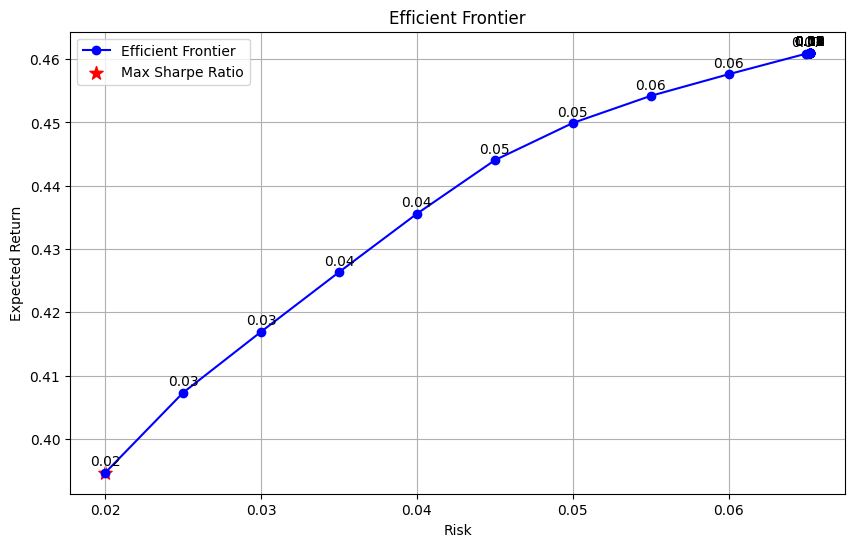

In [11]:
plot_efficient_frontier(results_df_1, "avg_dd")

C-DaR

In [12]:
#m, x, u = maxdd_model(cum_returns_1yr, 0.08, x_min, x_max)
gamma_lst = list(np.arange(0.02, 0.15, 0.005))
results_cdar = []
results_cdar_weights = []
alpha = 0.95
for gamma in gamma_lst:
    m, x_var, _, z0_var, z_var, max_dd_var = cdar_model(
                    y, gamma, alpha, x_min, x_max)
    m.optimize()

    # 1) 최적 비중 벡터
    w_opt = np.array([x_var[i].X for i in range(len(x_var))])
    port_path = y.values @ w_opt          # 누적 수익 시계열
    running   = np.maximum.accumulate(port_path)
    drawdown  = running - port_path

    maxdd_real = drawdown.max()           # 실제 MaxDD
    cdar_real  = 0
    thresh   = z0_var.X
    excess   = np.maximum(drawdown - thresh, 0).mean()
    cdar_real = thresh + excess / (1-alpha)

    R = m.ObjVal

    print(f"Avg DD (actual) = {avg_dd:.4f}")
    print(f"Optimal Weights  = {x_opt}")
    print(f"Sum of Weights   = {x_opt.sum():.4f}")
    results_cdar.append({
        "gamma": gamma,
        "CDaR": cdar_real,
        "ObjVal": R,
        "Reward/Risk": R / cdar_real
    })
    optimal_weight = dict(zip(y.columns, x_opt))
    results_cdar_weights.append(optimal_weight)
results_df_1 = pd.DataFrame(results_cdar)
results_df_2 = pd.DataFrame(results_cdar_weights)
merged_df_cdar = pd.concat([results_df_1.T, results_df_2.T], axis=0)
merged_df_cdar.to_csv("CDaR_results.csv")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13400F, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1010 rows, 555 columns and 39361 nonzeros
Model fingerprint: 0x7e7e30ef
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [3e-03, 6e-01]
  Bounds range     [5e-03, 5e-01]
  RHS range        [2e-02, 1e+00]
Presolve removed 468 rows and 2 columns
Presolve time: 0.01s
Presolved: 542 rows, 553 columns, 27424 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.02 seconds (0.02 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
     168    1.5008687e-01   0.000000e+00   0.000000e+00

c:\Users\chlwl\Projects\AdvancedPortfolioTheory\MinSeok\drawdown.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.setObjective(quicksum(x[i] * mu[i] for i in range(N)), GRB.MAXIMIZE)



CPU model: 13th Gen Intel(R) Core(TM) i5-13400F, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1010 rows, 555 columns and 39361 nonzeros
Model fingerprint: 0xb6f8b1de
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [3e-03, 6e-01]
  Bounds range     [5e-03, 5e-01]
  RHS range        [3e-02, 1e+00]
Presolve removed 468 rows and 2 columns
Presolve time: 0.01s
Presolved: 542 rows, 553 columns, 27424 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.02 seconds (0.02 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
     183    1.9240036e-01   0.000000e+00   0.000000e+00      0s

Solved in 183 iterations and 0.02 seconds (0.02 work units)
Optimal obje

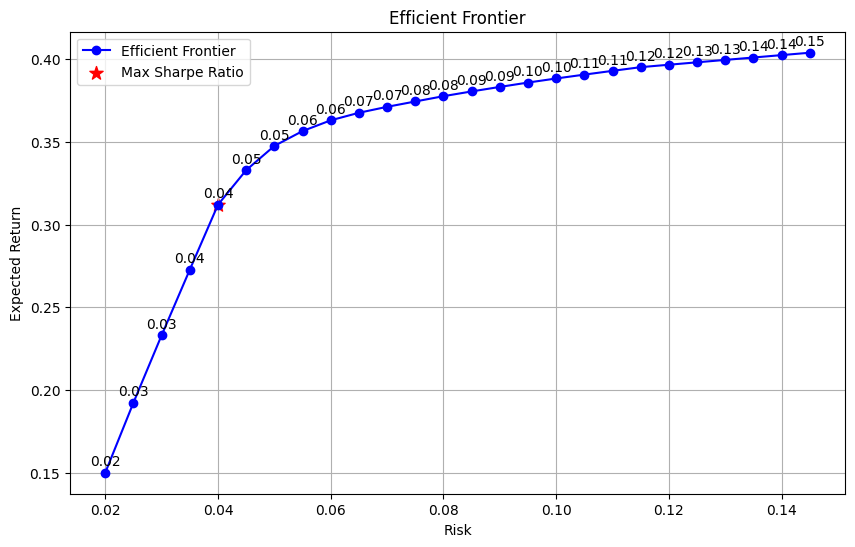

In [13]:
plot_efficient_frontier(results_df_1, "CDaR")

Conditional Drawdown at Risk vs Max DD

In [ ]:
gamma_lst = list(np.arange(0.05, 0.2, 0.01))
alpha_lst = [1, 0.95, 0.6, 0]
records = []          # (α, γ, R, MaxDD, CDaR) 저장

for alpha in alpha_lst:
    c_label = f"{int((1-alpha)*100)}% CDaR"

    for gamma in gamma_lst:

        # --- 모델 선택 ----------------------------------
        if alpha == 1:
            m, x_var, _, max_dd_var = maxdd_model(y, gamma, x_min, x_max) #, leverage='Y')
        else:
            m, x_var, _, z0_var, z_var, max_dd_var = cdar_model(
                    y, gamma, alpha, x_min, x_max) #, leverage='Y')

        m.optimize()

        # --- weight 벡터 & 경로 리스크 계산 ---------------
        w_opt = np.array([x_var[i].X for i in range(len(x_var))])
        port_path = y.values @ w_opt          # 누적 수익 시계열
        running   = np.maximum.accumulate(port_path)
        drawdown  = running - port_path

        maxdd_real = drawdown.max()           # 실제 MaxDD
        cdar_real  = 0
        if alpha != 1:
            thresh   = z0_var.X
            excess   = np.maximum(drawdown - thresh, 0).mean()
            cdar_real = thresh + excess / (1-alpha)

        R = m.ObjVal                          # 연환산 기대수익 (목적함수)

        records.append({
            "alpha": alpha,
            "c_label": c_label,
            "gamma": gamma,
            "R": R,
            "MaxDD": maxdd_real,
            "AvDD" : drawdown.mean(),
            "CDaR": cdar_real
        })

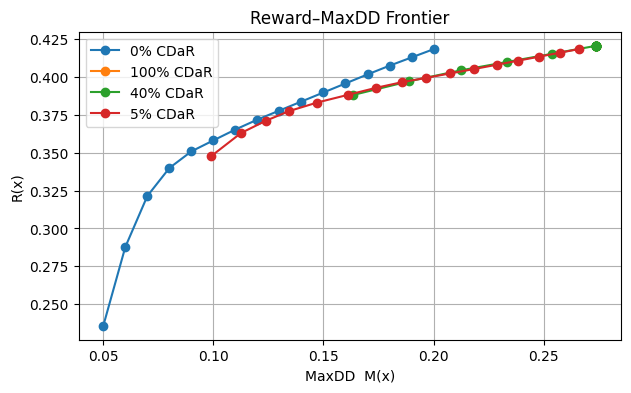

In [15]:
df = pd.DataFrame(records)

plt.figure(figsize=(7,4))
for c_label, grp in df.groupby("c_label"):
    plt.plot(grp["MaxDD"], grp["R"],
             marker='o', label=c_label)

plt.xlabel("MaxDD  M(x)")
plt.ylabel("R(x)")
plt.title("Reward–MaxDD Frontier")
plt.grid(True); plt.legend(); plt.show()

Conditional Drawdown at Risk vs Avg DD

In [16]:
gamma_lst = list(np.arange(0.03, 0.07, 0.005))
alpha_lst = [1, 0.95, 0.6, 0]
records = []          # (α, γ, R, MaxDD, CDaR) 저장

for alpha in alpha_lst:
    c_label = f"{int((1-alpha)*100)}% CDaR"

    for gamma in gamma_lst:

        # --- 모델 선택 ----------------------------------
        if alpha == 1:
            m, x_var, _, max_dd_var = maxdd_model(y, gamma, x_min, x_max) #, leverage='Y')
        else:
            m, x_var, _, z0_var, z_var, max_dd_var = cdar_model(
                    y, gamma, alpha, x_min, x_max) #, leverage='Y')

        m.optimize()

        # --- weight 벡터 & 경로 리스크 계산 ---------------
        w_opt = np.array([x_var[i].X for i in range(len(x_var))])
        port_path = y.values @ w_opt          # 누적 수익 시계열
        running   = np.maximum.accumulate(port_path)
        drawdown  = running - port_path

        maxdd_real = drawdown.max()           # 실제 MaxDD
        cdar_real  = 0
        if alpha != 1:
            thresh   = z0_var.X
            excess   = np.maximum(drawdown - thresh, 0).mean()
            cdar_real = thresh + excess / (1-alpha)

        R = m.ObjVal                          # 연환산 기대수익 (목적함수)

        records.append({
            "alpha": alpha,
            "c_label": c_label,
            "gamma": gamma,
            "R": R,
            "MaxDD": maxdd_real,
            "AvDD" : drawdown.mean(),
            "CDaR": cdar_real
        })

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13400F, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 757 rows, 302 columns and 25752 nonzeros
Model fingerprint: 0x8b9944d7
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [3e-03, 6e-01]
  Bounds range     [5e-03, 5e-01]
  RHS range        [3e-02, 1e+00]
Presolve removed 468 rows and 1 columns
Presolve time: 0.01s
Presolved: 289 rows, 552 columns, 13758 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8960805e-01   6.057384e+01   0.000000e+00      0s
     313    1.1079477e-01   0.000000e+00   0.000000e+00      0s

Solved in 313 iterations and 0.01 seconds (0.02 work units)
Optimal objective  1.107947675e-01


c:\Users\chlwl\Projects\AdvancedPortfolioTheory\MinSeok\drawdown.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.setObjective(quicksum(x[i] * mu[i] for i in range(N)), GRB.MAXIMIZE)


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13400F, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 757 rows, 302 columns and 25752 nonzeros
Model fingerprint: 0x6101d882
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [3e-03, 6e-01]
  Bounds range     [5e-03, 5e-01]
  RHS range        [3e-02, 1e+00]
Presolve removed 468 rows and 1 columns
Presolve time: 0.01s
Presolved: 289 rows, 552 columns, 13758 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8960805e-01   6.060634e+01   0.000000e+00      0s
     291    1.4657071e-01   0.000000e+00   0.000000e+00      0s

Solved in 291 iterations and 0.01 seconds (0.02 work units)
Optimal objective  1.465707084e-01
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen I

c:\Users\chlwl\Projects\AdvancedPortfolioTheory\MinSeok\drawdown.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.setObjective(quicksum(x[i] * mu[i] for i in range(N)), GRB.MAXIMIZE)



CPU model: 13th Gen Intel(R) Core(TM) i5-13400F, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1010 rows, 555 columns and 39361 nonzeros
Model fingerprint: 0xa1c348b5
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [3e-03, 6e-01]
  Bounds range     [5e-03, 5e-01]
  RHS range        [3e-02, 1e+00]
Presolve removed 468 rows and 2 columns
Presolve time: 0.01s
Presolved: 542 rows, 553 columns, 27424 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.02 seconds (0.02 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
     147    2.7273352e-01   0.000000e+00   0.000000e+00      0s

Solved in 147 iterations and 0.02 seconds (0.02 work units)
Optimal obje

In [17]:
gamma_lst = list(np.arange(0.03, 0.2, 0.005))
alpha_lst = [1, 0.95, 0.6, 0]

records = []      # (α,γ,R,AvDD,MaxDD,CDaR)

records = []        # 여기다 한 줄씩 dict 넣기

for alpha in alpha_lst:
    for gamma in gamma_lst:
        c_label = f"{int((1-alpha)*100)}% CDaR"
        # ──────────────────────────────────────
        # ① 모델 호출 (alpha 값에 따라 3‑Way 분기)
        # ──────────────────────────────────────
        if alpha == 1:                      # ---- MaxDD 모델 ----
            m, x_var, _, maxdd_var = maxdd_model(y, gamma, x_min, x_max)

        elif alpha == 0:                    # ---- AvDD 모델 ----
            m, x_var, _, dd_var   = avgdd_model(y, gamma, x_min, x_max)

        else:                               # ---- CDaR + MaxDD ----
            m, x_var,u, z0_var, z_var, maxdd_var = cdar_model(
                    y, gamma, alpha, x_min, x_max)

        m.optimize()

        # ──────────────────────────────────────
        # ② 포트폴리오 경로 및 리스크 계산
        # ──────────────────────────────────────
        w_opt      = np.array([x_var[i].X for i in range(len(x_var))])
        path       = y.values @ w_opt
        running    = np.maximum.accumulate(path)
        drawdown   = running - path

        maxdd_real = drawdown.max()
        avdd_real  = drawdown.mean()
        cdar_real  = None

        if 0 < alpha < 1:
            thresh     = z0_var.X
            excess     = np.maximum(drawdown - thresh, 0).mean()
            cdar_real  = thresh + excess / (1 - alpha)

        # ──────────────────────────────────────
        # ③ 결과 dict 만들어 records 에 추가
        # ──────────────────────────────────────
        records.append({
            "alpha" : alpha,
            "gamma" : gamma,
            "R"     : m.ObjVal,        # 목적함수 값 (연환산 기대수익)
            "MaxDD" : maxdd_real,
            "AvDD"  : avdd_real,
            "CDaR"  : cdar_real,
            "c_label" : c_label                # CDaR 계산된 경우만 숫자, else None
        })

# DataFrame 으로 변환해 사용
df_results = pd.DataFrame(records)
print(df_results.head())

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13400F, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 757 rows, 302 columns and 25752 nonzeros
Model fingerprint: 0x8b9944d7
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [3e-03, 6e-01]
  Bounds range     [5e-03, 5e-01]
  RHS range        [3e-02, 1e+00]
Presolve removed 468 rows and 1 columns
Presolve time: 0.01s
Presolved: 289 rows, 552 columns, 13758 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8960805e-01   6.057384e+01   0.000000e+00      0s
     313    1.1079477e-01   0.000000e+00   0.000000e+00      0s

Solved in 313 iterations and 0.01 seconds (0.02 work units)
Optimal objective  1.107947675e-01
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen I

c:\Users\chlwl\Projects\AdvancedPortfolioTheory\MinSeok\drawdown.py:219: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.setObjective(quicksum(x[i] * mu[i] for i in range(N)), GRB.MAXIMIZE)


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13400F, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 757 rows, 553 columns and 26255 nonzeros
Model fingerprint: 0x535137f7
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [3e-03, 6e-01]
  Bounds range     [5e-03, 5e-01]
  RHS range        [3e-02, 1e+00]
Presolve removed 215 rows and 0 columns
Presolve time: 0.01s
Presolved: 542 rows, 553 columns, 27182 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8960805e-01   1.187976e+02   0.000000e+00      0s
     341    4.2634648e-01   0.000000e+00   0.000000e+00      0s

Solved in 341 iterations and 0.02 seconds (0.03 work units)
Optimal objective  4.263464797e-01
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen I

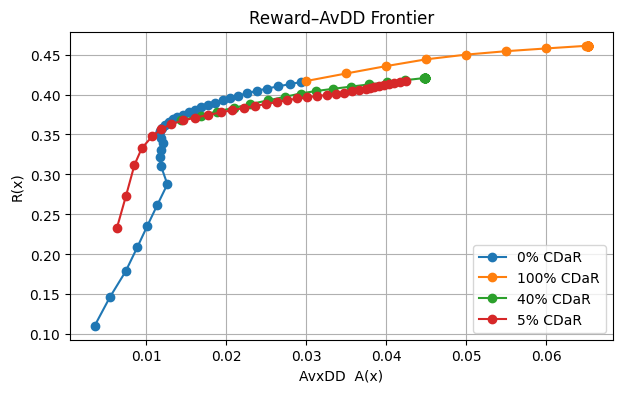

In [18]:
plt.figure(figsize=(7,4))
for c_label, grp in df_results.groupby("c_label"):
    plt.plot(grp["AvDD"], grp["R"],
             marker='o', label=c_label)

plt.xlabel("AvxDD  A(x)")
plt.ylabel("R(x)")
plt.title("Reward–AvDD Frontier")
plt.grid(True); plt.legend(); plt.show()

과거 로그수익률 정상성 검사, GARCH 피팅 후 파라미터 정상성 검정, 못쓰는 자산 제거

In [99]:
log_ret_lst_1yr, log_ret_lst_3yr, unstationary_1yr, unstationary_3yr = check_stationary(selected_price_data)

In [100]:
result_lst = []

In [84]:
remove_assets = ['KMI', 'AJG', 'MS', 'BSX', 'MSFT', 'ACN']

filtered_df_1yr = log_ret_lst_1yr.drop(columns=remove_assets)

In [ ]:
params_df, C, Z = fit_garch_df(filtered_df_1yr)

C:\Users\채민석\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02058. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\채민석\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002914. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be

In [103]:
filtered_df_3yr = log_ret_lst_3yr.drop(columns=['AVGO'])

In [105]:
for i in list(params_df.index):
    if params_df.loc[i, 'alpha']+params_df.loc[i, 'beta'] >= 1:
        print(i)

다변수 몬테카를로 시뮬레이션(잔차 상관관계 고려)

In [106]:
simulated_prices = monte_carlo_with_correlation(757, selected_price_data, params_df, C)
print(f"생성된 경로 shape: {simulated_prices.shape}")  # (252, 1000, 3)

생성된 경로 shape: (757, 1000, 48)


수익 단순 누적합 계산

In [108]:
def cumulative_returns_simple(simulated_prices):
    """
    Monte Carlo 시뮬레이션 결과에서 누적 수익률 계산 (단순 수익률 기반)
    - simulated_prices: (T, n_sim, n_assets) 배열
    """
    T, n_sim, n_assets = simulated_prices.shape

    # 단순 수익률 계산
    simple_returns = simulated_prices[1:] / simulated_prices[:-1] - 1

    # 누적 수익률 계산
    cum_returns = np.cumsum(simple_returns, axis=0)

    # DataFrame 형태로 변환 (자산별로 누적 수익률 포함)
    cum_returns_df = {}
    for asset in range(n_assets):
        asset_name = list(filtered_df_3yr)[asset]
        # 각 자산의 누적 수익률을 DataFrame으로 저장
        cum_returns_df[asset_name] = pd.DataFrame(cum_returns[:, :, asset], 
                                                 columns=[f"Path_{i+1}" for i in range(n_sim)])
    return cum_returns_df

# 누적 수익률 계산
cum_returns_df = cumulative_returns_simple(simulated_prices)

# 첫 번째 자산의 누적 수익률 확인


In [109]:
# cum_returns_df를 DataFrame으로 변환하여 CSV로 저장
for key, value in cum_returns_df.items():
    # value가 DataFrame인지 확인 후 저장
    if isinstance(value, pd.DataFrame):
        value.to_csv(f"cum_returns_df_{key}_3yr.csv", index=True, encoding='utf-8-sig')
    else:
        print(f"'{key}'는 DataFrame이 아닙니다.")


path 별 자산 CDaR 계산

In [16]:
def extract_path(cum_returns_df, path_name):
    """
    모든 자산에 대해 특정 경로의 값을 추출
    - cum_returns_df: 누적 수익률 데이터프레임 사전
    - path_name: 추출할 경로 이름 (예: 'Path_1')
    """
    # 모든 자산에 대해 Path_1 값 추출
    path_values = {asset_name: df[path_name] for asset_name, df in cum_returns_df.items()}
    
    # DataFrame으로 변환
    path_df = pd.DataFrame(path_values)
    return path_df

def test_cdar_multiple_paths(cum_returns_df, gamma, alpha, x_min, x_max):
    """
    CDaR 테스트 함수 (경로별 최적화)
    - cum_returns_df: 누적 수익률 DataFrame 사전 (자산별로 나뉨)
    - gamma: 허용 최대 CDaR
    - alpha: 신뢰수준 (예: 0.95)
    """
    optimal_weights_list = []
    cdar_values = []
    results_cdar_mc = []
    error_path = []
    # 각 경로를 반복 실행
    num_paths = list(cum_returns_df.values())[0].shape[1]  # 경로 수
    for path in range(num_paths):
        try : 
            
            print(f"🔍 경로 {path+1}/{num_paths} 테스트 중...")
            
            # 경로별 데이터프레임 구성 (자산 x 기간 형태로 전환)
            y = extract_path(cum_returns_df, f'Path_{path+1}')
            y.columns = cum_returns_df.keys()
            
            # 기존 CDaR 함수 활용
            model, x_var, u_var, z0_var, z_var = cdar_model(y, gamma, alpha,
                                                    x_min, x_max)
            model.optimize()

            # 최적 비중
            x_opt = np.array([x_var[i].X for i in range(len(x_var))])

            # 실제 CDaR 계산 (검증용)
            w_vals  = y.values @ x_opt
            u_vals  = np.maximum.accumulate(w_vals)
            dd_vals = u_vals - w_vals
            threshold = z0_var.X
            excess   = np.maximum(dd_vals - threshold, 0)
            cdar = threshold + excess.mean() / (1 - alpha)

            print(f"CDaR   = {cdar:.4f} (γ = {gamma})")
            print(f"max DD = {dd_vals.max():.4f}")
            results_cdar_mc.append({
                    "path" : path+1,
            "gamma": gamma,
            "cdar": cdar,
            "ObjVal": model.ObjVal,
            "Reward/Risk": model.ObjVal / cdar, 
            "z" : z0_var.X,
            "maxdd" : dd_vals.max()
        })
            optimal_weight = dict(zip(y.columns, x_opt))
            optimal_weights_list.append(optimal_weight)
                
        except:
            error_path.append(path+1)
    results_df_1 = pd.DataFrame(results_cdar_mc)
    results_df_2 = pd.DataFrame(optimal_weights_list)
    merged_df_avgdd = pd.concat([results_df_1.T, results_df_2.T], axis=0)
    merged_df_avgdd.to_csv(f"cdar_results_mc_{alpha}_{gamma}.csv")    


In [ ]:
# 테스트 파라미터 설정
gamma_lst = list(np.arange(0.03, 0.13, 0.01))  # 허용 최대 CDaR
alpha = 0.95  # 신뢰수준

# CDaR 모델 테스트 실행 (다중 경로 기반)
for gamma in gamma_lst:
    test_cdar_multiple_paths(cum_returns_df, gamma, alpha, x_min, x_max)

